In [34]:
import numpy as np
import math
import random
import torch
import carla
import time
import matplotlib.pyplot as plt

In [35]:
client = carla.Client('localhost', 2000)
client.set_timeout(10.0)
world = client.load_world('Town03')

In [36]:
blueprint_library = world.get_blueprint_library()
vehicle_bp = blueprint_library.filter("vehicle.audi.tt")[0]
starting_point = world.get_map().get_spawn_points()[0]
vehicle = world.try_spawn_actor(vehicle_bp,starting_point)
vehicle_pos = vehicle.get_transform()
lidar_bp = blueprint_library.find('sensor.lidar.ray_cast')
lidar_blueprint = blueprint_library.find("sensor.lidar.ray_cast")
lidar_blueprint.set_attribute("channels", str(32))
lidar_blueprint.set_attribute("points_per_second", str(100000))
lidar_blueprint.set_attribute("rotation_frequency", str(10.0))
lidar_blueprint.set_attribute("upper_fov", str(30.0))
lidar_blueprint.set_attribute("lower_fov", str(-25.0))
lidar_blueprint.set_attribute("range", str(100.0))
spectator_rotation = vehicle_pos.rotation
lidar_transform = carla.Transform(starting_point.location, spectator_rotation)
lidar_sensor = world.spawn_actor(lidar_blueprint, lidar_transform, attach_to = vehicle)

In [ ]:
bounding_box = vehicle.bounding_box
vehicle_length = bounding_box.extent.x

In [38]:
def get_steering_angle(vehicle_location, target_location):
    dx = target_location[0] - vehicle_location.location.x
    dy = target_location[1] - vehicle_location.location.y
    angle_to_target = math.atan2(dy, dx)
    current_yaw = math.radians(vehicle_location.rotation.yaw)
    steering_angle = angle_to_target - current_yaw
    steering_angle = (steering_angle + math.pi) % (2 * math.pi) - math.pi  # Normalize to [-π, π]
    return steering_angle
    

In [39]:
def calculate_throttle(vehicle_location, target_location):
    max_throttle = 0.95
    dx = target_location[0] - vehicle_location.location.x
    dy = target_location[1] - vehicle_location.location.y
    distance_to_target = math.sqrt(dx**2 + dy**2)
    # throttle = min(1.0, distance_to_target * 0.05)
    if distance_to_target > 20.0:
        throttle = max_throttle
    elif distance_to_target > 10.0:
        throttle = max_throttle * 0.5
    else:
        throttle = max_throttle * 0.3
    return throttle

In [ ]:
# Node class representing a state in the space
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.cost = 0

# RRT* algorithm
class RRTStar:
    def __init__(self, vehicle_length, start, goal,map_size, carla_world, vehicle, lidar_sensor,step_size=1.0, max_iter=900):
        self.start = Node(start[0],start[1])
        self.goal = Node(goal[0], goal[1])
        self.map_size = map_size
        self.step_size = step_size
        self.max_iter = max_iter
        self.node_list = [self.start]
        self.goal_region_radius = 1.5
        self.search_radius = 2.0
        self.path = None
        self.goal_reached = False
        self.carla_world = carla_world
        self.vehicle = vehicle
        self.lidar_sensor = lidar_sensor 
        self.lidar_data = []
        self.vehicle_length = vehicle_length
        
    def process_lidar_data(self, data):
        points = np.frombuffer(data.raw_data, dtype=np.float32).reshape(-1, 4)  # Each point has 4 values (x, y, z, intensity)
        self.lidar_data = points[:, :3]  # Extract x, y, z coordinates
        print("Lidar Data Updated:", self.lidar_data)
        
    def get_lidar_data(self):
        self.lidar_sensor.listen(lambda data: self.process_lidar_data(data))
        
    def get_nearest_node(self, node_list, rand_node):
        distances = [np.linalg.norm([node.x - rand_node.x, node.y - rand_node.y]) for node in node_list]
        nearest_node_idx = np.argmin(distances)
        return node_list[nearest_node_idx]
    
    def is_collision_free(self, node):
        for point in self.lidar_data:
            distance = math.sqrt((point[0] - node.x) ** 2 + (point[1] - node.y) ** 2)
            if distance <= self.vehicle_length / 2:  # Use vehicle dimensions for clearance
                return False
        return True
    
    def get_random_node(self):
        if random.random() > 0.2:
            return Node(random.uniform(0, self.map_size[0]), random.uniform(0, self.map_size[1]))
        else:
            return Node(self.goal.x, self.goal.y)
    
    def choose_parent(self, neighbors, nearest_node, new_node):
        """Choose the best parent for the new node based on cost."""
        min_cost = nearest_node.cost + np.linalg.norm([new_node.x - nearest_node.x, new_node.y - nearest_node.y])
        best_node = nearest_node
        for neighbor in neighbors:
            cost = neighbor.cost + np.linalg.norm([new_node.x - neighbor.x, new_node.y - neighbor.y])
            if cost < min_cost and self.is_collision_free(neighbor):
                best_node = neighbor
                min_cost = cost
        new_node.cost = min_cost
        new_node.parent = best_node
        return new_node

    def find_neighbors(self, new_node):
        """Find nearby nodes within the search radius."""
        return [node for node in self.node_list
                if np.linalg.norm([node.x - new_node.x, node.y - new_node.y]) < self.search_radius]

    def rewire(self, new_node, neighbors):
        """Rewire the tree by checking if any neighbor should adopt the new node as a parent."""
        for neighbor in neighbors:
            cost = new_node.cost + np.linalg.norm([neighbor.x - new_node.x, neighbor.y - new_node.y])
            if cost < neighbor.cost and self.is_collision_free(neighbor):
                neighbor.parent = new_node
                neighbor.cost = cost

    def reached_goal(self, node):
        """Check if the goal has been reached."""
        return np.linalg.norm([node.x - self.goal.x, node.y - self.goal.y]) < self.goal_region_radius

    def steer(self, from_node, to_node):
        """Steer from one node to another, step-by-step."""
        theta = math.atan2(to_node.y - from_node.y, to_node.x - from_node.x)
        new_node = Node(from_node.x + self.step_size * math.cos(theta),
                        from_node.y + self.step_size * math.sin(theta))
        new_node.cost = from_node.cost + self.step_size
        new_node.parent = from_node
        return new_node
    
    def move_vehicle_along_path(self):
        if self.path:
            for point in self.path:
                target_location = point   
                vehicle_pos = self.vehicle.get_transform()  
                steering_angle = get_steering_angle(vehicle_pos, target_location)
                steering = steering_angle * 0.02
                throttle = calculate_throttle(vehicle_pos, target_location)
                print(vehicle_pos)
                self.vehicle.apply_control(carla.VehicleControl(throttle=throttle, brake=0.0, steer=steering))
                print("##################")
                print(self.vehicle.get_transform().location)
                print("##################")
                print(vehicle.get_transform().location)
        else:
            self.vehicle.apply_control(carla.VehicleControl(throttle=0, brake=10.0, steer=0))
            print("no path to follow.")

    def generate_final_path(self, goal_node):
        """Generate the final path from the start to the goal and drive along it."""
        path = []
        node = goal_node
        while node is not None:
            path.append([node.x, node.y])
            node = node.parent
        path = path[::-1]
        print(path)
        X = [point[0] for point in path]
        Y = [point[1] for point in path]
        plt.scatter(X, Y, color='red', label='path')
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("Path Visualization")
        plt.legend()
        plt.show()
        return path        

    def plan(self):
        """Main RRT* planning loop."""
        for i in range(self.max_iter):
            
            rand_node = self.get_random_node()
            nearest_node = self.get_nearest_node(self.node_list, rand_node)
            new_node = self.steer(nearest_node, rand_node)

            if self.is_collision_free(new_node):
                neighbors = self.find_neighbors(new_node)
                new_node = self.choose_parent(neighbors, nearest_node, new_node)
                self.node_list.append(new_node)
                self.rewire(new_node, neighbors)

            if (self.reached_goal(new_node)):
                    self.path = self.generate_final_path(new_node)
                    self.goal_reached = True
                    self.move_vehicle_along_path()
                    return
        if not self.goal_reached:
                    print("Goal not reached after maximum iterations. Adjusting parameters...")
                    # self.step_size *= 0.8 
                    # self.max_iter += 100  
                    # print(f"New step size: {self.step_size}, New max iterations: {self.max_iter}")
    
    def prints(self):
        print(f"Goal Reached: {self.goal_reached}")
        print(f"Number of Nodes: {len(self.node_list)}") 
        
        

In [41]:
def main():  
    try:
        start_location = [starting_point.location.x, starting_point.location.y]
        goal_location = [start_location[0]+ 5, start_location[1] + 2]
        rrt_star = RRTStar(start=start_location, vehicle_length= vehicle_length,goal=goal_location, map_size=[100, 100], carla_world=world, vehicle=vehicle, lidar_sensor=lidar_sensor)
        rrt_star.plan()
        rrt_star.prints()
    finally:
        print("Simulation ended.")

[[-6.446169853210449, -79.05502319335938], [-6.1237913104289134, -78.1084123571896], [-4.38833057325939, -77.33963661570141], [-3.392976933827078, -77.243349895595], [-2.038932175366642, -76.77593972586396]]


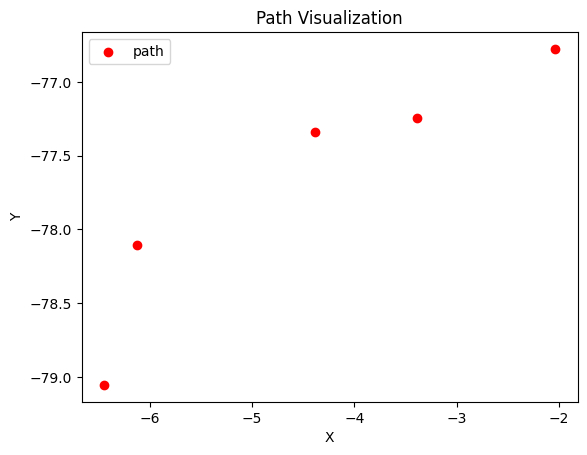

Transform(Location(x=-6.446170, y=-79.055023, z=-0.012044), Rotation(pitch=0.000000, yaw=92.004189, roll=0.000000))
##################
Location(x=-6.446170, y=-79.055023, z=-0.012044)
##################
Location(x=-6.446170, y=-79.055023, z=-0.012044)
Transform(Location(x=-6.446170, y=-79.055023, z=-0.012044), Rotation(pitch=0.000000, yaw=92.004189, roll=0.000000))
##################
Location(x=-6.446170, y=-79.055023, z=-0.012044)
##################
Location(x=-6.446170, y=-79.055023, z=-0.012044)
Transform(Location(x=-6.446170, y=-79.055023, z=-0.012044), Rotation(pitch=0.000000, yaw=92.004189, roll=0.000000))
##################
Location(x=-6.446170, y=-79.055023, z=-0.012044)
##################
Location(x=-6.446170, y=-79.055023, z=-0.012044)
Transform(Location(x=-6.446170, y=-79.055023, z=-0.012044), Rotation(pitch=0.000000, yaw=92.004189, roll=0.000000))
##################
Location(x=-6.446170, y=-79.055023, z=-0.012044)
##################
Location(x=-6.446170, y=-79.055023, z=-0.

In [42]:
if __name__ == "__main__":
    main()

In [43]:
vehicle.destroy()
lidar_sensor.destroy()

False